This Notebook is designed to perform Exploratory Data Analysis for both Synthetic Dataset & Farm Yield Dataset. IF you want to explore usage of other datasets, you can load them directly in this notebook or make appropriate changes in src/data_loaders.py

In [1]:
# Importing all the dependencies required

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import StandardScaler as stdscaler
from sklearn.model_selection import train_test_split as tts
import joblib

In [2]:
# This allows .py files defined in src to be used in notebooks
import os
import sys

src_path = os.path.abspath(os.path.join('..', 'src'))

if src_path not in sys.path:
    sys.path.append(src_path)
    
from data_loaders import data_loading_preprocessing


Firstly, The synthetic datasets are generated using functions defined in src/data_loaders.py. 
Follwed by performing EDA

In [3]:
# Generating the synthetic dataset 
# data_loading_preprocessing takes following input => 
#       type of data generated, number of samples, features, & informative features along with noise, multicollinearity_strength
syn_X, syn_y, true_beta = data_loading_preprocessing(100, 15, 7, 0.23, 0.6)

Generating Synthetic Dataset with 100 samples and 15 features.
Correlation Clusters Generation Successfully
Apply correlation to clusters generated successfully!!
Synthetic Data Generation Successful


In [4]:
# Coefficients
true_beta

array([-3.21747533,  0.        , -3.26519926,  0.        ,  1.37553264,
       -0.03833616,  0.        , -2.0055649 ,  0.        ,  3.01366916,
        2.66588524,  2.3361583 ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [5]:
# Removing Intercept from syn_X 
syn_X_1 = syn_X.copy().drop(['Intercept'], axis=1)
print(syn_X_1.head())

   Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  Feature 6  \
0   0.907240  -0.138264   0.997825   1.523030  -0.234153   0.468730   
1  -0.700582  -1.012831  -0.174661  -0.908024  -1.412304   0.516180   
2  -0.784108   1.852278  -0.431183  -1.057711   0.822545  -1.155591   
3  -0.294459  -0.460639   0.771721   0.343618  -1.763040   0.331898   
4  -0.765987  -0.185659  -1.142284  -1.196207   0.812526   0.335261   

   Feature 7  Feature 8  Feature 9  Feature 10  Feature 11  Feature 12  \
0   1.579213  -0.148751  -0.469474    0.542560   -0.463418    0.329774   
1  -0.225776   0.403727  -1.424748   -0.544383    0.110923   -1.053806   
2   0.208864  -0.752718  -1.328186    0.196861    0.738467   -0.320263   
3  -0.385082  -0.543601   0.611676    1.031000    0.931280   -0.366083   
4  -0.072010   1.080602   0.361636   -0.645120    0.361396    0.444339   

   Feature 13  Feature 14  Feature 15  
0   -0.464035   -0.538756   -0.425739  
1    0.588628   -0.723593   -0.538226  
2    0.3

Heatmap of both the original and normalised synthetic data to understand correlations

In [6]:
# helper function to create heat maps
def heatmap(matrix, title, save_path = "results/figures", fig_size=(8, 8)):
    n_features = len(matrix.columns)
    fig = plt.figure(figsize=(n_features * 0.5 + 2, n_features * 2 + 2))
    ax = plt.subplot()
    im = ax.imshow(matrix)

    # Setting ticks for X axis and y axis
    ax.set_xticks(range(matrix.shape[0]), labels=matrix.columns, 
                rotation = 30, ha="right", rotation_mode="anchor")

    ax.set_yticks(range(matrix.shape[0]), 
                labels = matrix.columns)

    # removing spines and adding white grids to the heatmap
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(matrix.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(matrix.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

    # adding correlation value for each pixel

    # Rounding off the correlation values to .2f and normalising to [0, 1]
    matrix = matrix.apply(lambda x: round(x, 2))


    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[0]):
            color = None
            corr_val = matrix.iloc[j, i]
            if corr_val < 0:
                color = "w"
            im.axes.text(j, i, corr_val , va="center", ha = "center", color=color)
            
    # Displaying the correlation range
    fig.colorbar(im, cax=inset_axes(ax, width="6%", height="100%", loc="center right", bbox_to_anchor=(0.1, 0, 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0,), orientation = 'vertical', label = "Correlation Coefficient" )
    
    # Title of the plot
    plt.title(title, loc="right")
    
    if save_path:
        try:
            # Create the directory if it doesn't exist
            cwd = os.getcwd()
            root_dirname = os.path.dirname(cwd)
            title_ = title.replace(" ", "-")
            figure_path = os.path.join(root_dirname, save_path, f"{title_}.png")
            plt.savefig(figure_path, bbox_inches='tight', dpi=300)
            print(f"Plot saved successfully to: {figure_path}")
        except Exception as e:
            print(f"Error saving plot to {save_path}: {e}")
            
    plt.show()

Plot saved successfully to: C:\random\Desktop\ResearchTopics\RS1\results/figures\Correlation-Heat-Map-of-Synthetically-Generated-Matrix.png


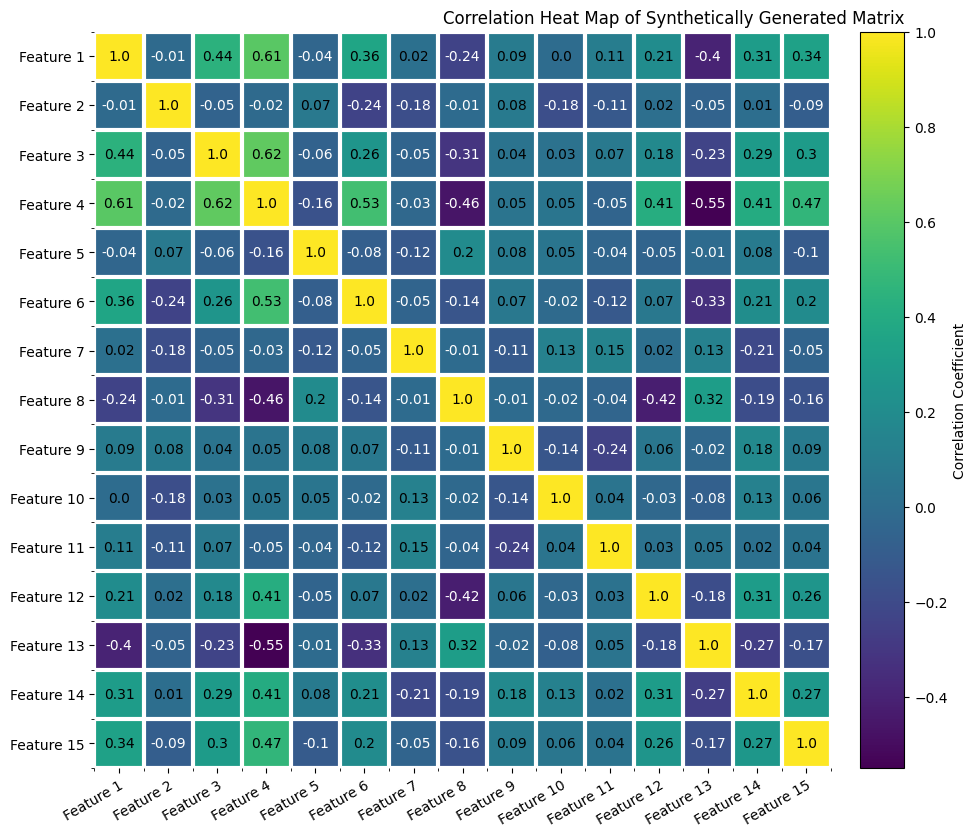

In [7]:
# Heatmap of original synthetic data
syn_corr_matrix = syn_X_1.corr()
heatmap(syn_corr_matrix, "Correlation Heat Map of Synthetically Generated Matrix")

Calculating the VIF scores for better multicollinearity understanding

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_syn_data = pd.DataFrame()
vif_syn_data['features']= syn_X_1.columns

vif_syn_data['VIF'] = [variance_inflation_factor(syn_X_1.values, i)
                       for i in range(len(syn_X_1.columns))]

vif_syn_data

,features,VIF
0,Feature 1,1.782314
1,Feature 2,1.221311
2,Feature 3,1.822174
3,Feature 4,4.656788
4,Feature 5,1.127328
5,Feature 6,1.712710
6,Feature 7,1.186611
7,Feature 8,1.497437
8,Feature 9,1.166244
9,Feature 10,1.142995


Data Splitting of synthetic data: both original & normalised

In [9]:
# 80% data as train data 
train_ratio = 0.8

# original synthetic data splitting
X_syn_train, X_syn_test, y_syn_train, y_syn_test = tts(syn_X_1, syn_y, train_size =  train_ratio)

# normalising the synthetic data
scaler_x = stdscaler()
scaler_y = stdscaler()
X_syn_train_scaled = scaler_x.fit_transform(X_syn_train)
X_syn_test_scaled = scaler_x.transform(X_syn_test)
y_syn_train_scaled = scaler_y.fit_transform(y_syn_train)
y_syn_test_scaled = scaler_y.transform(y_syn_test)

# Concrete Compression Strength

###### This dataset can be as per user choice

In [10]:
# A dataset was pre-downloaded for this. Other methods of incorporating real-world datasets can be considered
cwd = os.getcwd()
data_path = os.path.join(os.path.dirname(cwd), "data\\raw\Concrete_Compressive_Strength.csv")
ccs_df = pd.read_csv(data_path)

In [11]:
ccs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Cement                          1030 non-null   float64
 1   Blast Furnace Slag              1030 non-null   float64
 2   Fly Ash                         1030 non-null   float64
 3   Water                           1030 non-null   float64
 4   Superplasticizer                1030 non-null   float64
 5   Coarse Aggregate                1030 non-null   float64
 6   Fine Aggregate                  1030 non-null   float64
 7   Age (day)                       1030 non-null   int64  
 8   Concrete compressive strength   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [12]:
ccs_corr = ccs_df.corr()

Plot saved successfully to: C:\random\Desktop\ResearchTopics\RS1\results/figures\Correlation-Heatmap-of-Concrete-Compression-Strength-Dataset.png


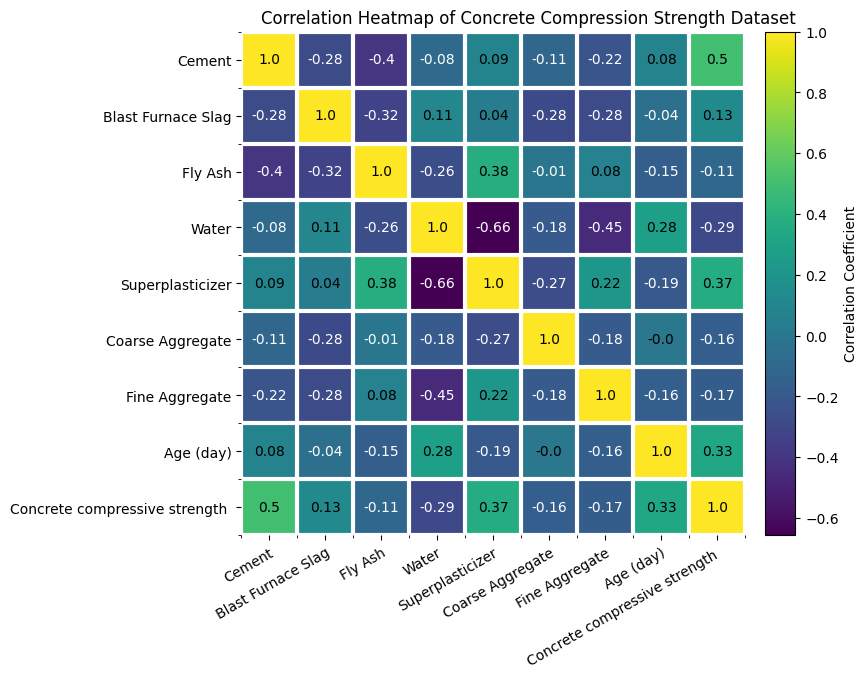

In [13]:
heatmap(ccs_corr, "Correlation Heatmap of Concrete Compression Strength Dataset")

VIF determination

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_ccs_data = pd.DataFrame()
vif_ccs_data['features']= ccs_df.columns

vif_ccs_data['VIF'] = [variance_inflation_factor(ccs_df.values, i)
                       for i in range(len(ccs_df.columns))]

vif_ccs_data

,features,VIF
0,Cement,26.248178
1,Blast Furnace Slag,4.444466
2,Fly Ash,4.561734
3,Water,92.512523
4,Superplasticizer,5.520316
5,Coarse Aggregate,85.900013
6,Fine Aggregate,73.522864
7,Age (day),2.434882
8,Concrete compressive strength,14.555916


In [15]:
# 80% data as train data 
train_ratio = 0.8

X_ccs, y_ccs = ccs_df.drop(columns=['Concrete compressive strength '], axis=1), ccs_df[["Concrete compressive strength "]]

# original synthetic data splitting
X_ccs_train, X_ccs_test, y_ccs_train, y_ccs_test = tts(X_ccs, y_ccs, train_size =  train_ratio)

# normalising the synthetic data
scaler_x_ccs = stdscaler()
scaler_y_ccs = stdscaler()
X_ccs_train_scaled = scaler_x_ccs.fit_transform(X_ccs_train)
X_ccs_test_scaled = scaler_x_ccs.transform(X_ccs_test)
y_ccs_train_scaled = scaler_y_ccs.fit_transform(y_ccs_train)
y_ccs_test_scaled = scaler_y_ccs.transform(y_ccs_test)

# Storing all the Synthetic & Real - World data

##  Synthetic Data

In [16]:
import joblib

cwd = os.getcwd()
root = os.path.dirname(cwd)
scaler_paths = os.path.join(root, r"models")
data_paths = os.path.join(root, r"data/processed")

In [17]:
# synthetic scalers 
joblib.dump(scaler_x, os.path.join(scaler_paths, "synthetic_scaler_x.pkl"))
joblib.dump(scaler_y, os.path.join(scaler_paths, "synthetic_scaler_y.pkl"))

# synthetic data
pd.DataFrame(X_syn_train_scaled).to_csv(os.path.join(data_paths, "synthetic_train_scaled_x.csv"), index= False)
pd.DataFrame(X_syn_test_scaled).to_csv(os.path.join(data_paths, "synthetic_test_scaled_x.csv"), index = False)
pd.DataFrame(y_syn_train_scaled).to_csv(os.path.join(data_paths, "synthetic_train_scaled_y.csv"), index = False)
pd.DataFrame(y_syn_test_scaled).to_csv(os.path.join(data_paths, "synthetic_test_scaled_y.csv"), index= False)

# synthetic true beta
pd.DataFrame(true_beta).to_csv(os.path.join(data_paths, "synthetic_true_beta.csv"), index = False)

In [18]:
# ccs scalers 
joblib.dump(scaler_x_ccs, os.path.join(scaler_paths, "ccs_scaler_x.pkl"))
joblib.dump(scaler_y_ccs, os.path.join(scaler_paths, "ccs_scaler_y.pkl"))

# ccs data

pd.DataFrame(X_ccs_train_scaled).to_csv(os.path.join(data_paths, "ccs_train_scaled_x.csv"), index= False)
pd.DataFrame(X_ccs_test_scaled).to_csv(os.path.join(data_paths, "ccs_test_scaled_x.csv"), index = False)
pd.DataFrame(y_ccs_train_scaled).to_csv(os.path.join(data_paths, "ccs_train_scaled_y.csv"), index = False)
pd.DataFrame(y_ccs_test_scaled).to_csv(os.path.join(data_paths, "ccs_test_scaled_y.csv"), index= False)


# Detailed Data Analysis of Synthetic Dataset

In [74]:
syn_X.head()

,Intercept,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15
0,1.0,0.907240,-0.138264,0.997825,1.523030,-0.234153,0.468730,1.579213,-0.148751,-0.469474,0.542560,-0.463418,0.329774,-0.464035,-0.538756,-0.425739
1,1.0,-0.700582,-1.012831,-0.174661,-0.908024,-1.412304,0.516180,-0.225776,0.403727,-1.424748,-0.544383,0.110923,-1.053806,0.588628,-0.723593,-0.538226
2,1.0,-0.784108,1.852278,-0.431183,-1.057711,0.822545,-1.155591,0.208864,-0.752718,-1.328186,0.196861,0.738467,-0.320263,0.353695,-0.603747,-1.310198
3,1.0,-0.294459,-0.460639,0.771721,0.343618,-1.763040,0.331898,-0.385082,-0.543601,0.611676,1.031000,0.931280,-0.366083,-0.322975,0.336205,0.722774
4,1.0,-0.765987,-0.185659,-1.142284,-1.196207,0.812526,0.335261,-0.072010,1.080602,0.361636,-0.645120,0.361396,0.444339,0.456987,0.460304,-2.050330


In [24]:
syn_y.head()

,target
0,-4.684808
1,-5.936880
2,-12.841682
3,6.377885
4,-3.811398


In [25]:
true_beta

array([-3.21747533,  0.        , -3.26519926,  0.        ,  1.37553264,
       -0.03833616,  0.        , -2.0055649 ,  0.        ,  3.01366916,
        2.66588524,  2.3361583 ,  0.        ,  0.        ,  0.        ,
        0.        ])

In [32]:
resulting_figure_path = os.path.join(root, r"results\figures")

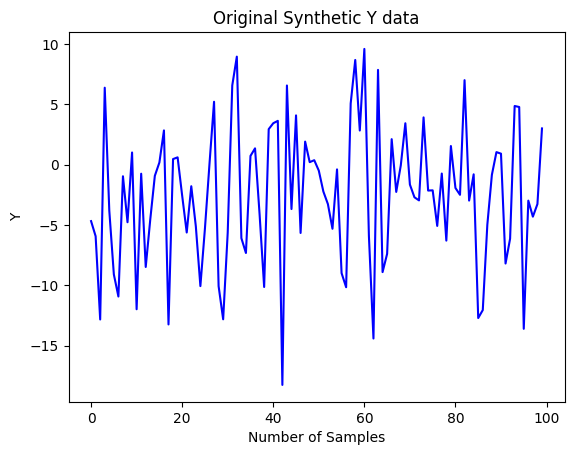

In [34]:
# plotting the y (target) values in the synthetic dataset

plt.plot(syn_y, color = "blue")
plt.title("Original Synthetic Y data")
plt.xlabel("Number of Samples")
plt.ylabel("Y", )
plt.savefig(os.path.join(resulting_figure_path, "Original_Synthetic_Y_data.png"))  
plt.show()

we observe that the plot is not entirely linear and high fluctuation is seen in the data.
The fluctuation maybe due to the noise that is being added to the linear equation during synthetic data generation

# Detailed Data Analysis of Concrete Compression Strength Dataset

In [75]:
ccs_df.info()

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age (day)',
       'Concrete compressive strength '],
      dtype='object')

No categorical features present hence feature encoding was skipped

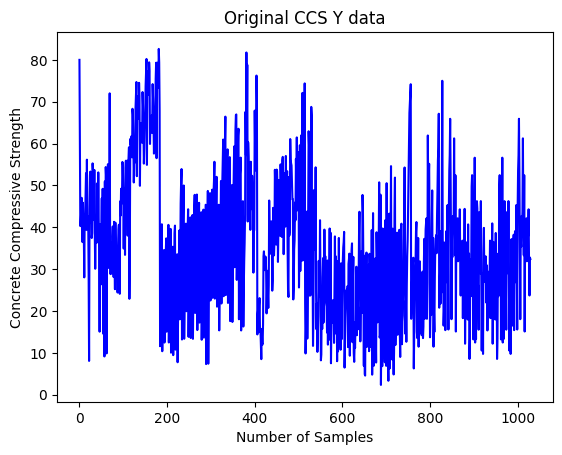

In [70]:
# Plotting the target feature
plt.plot(ccs_df['Concrete compressive strength '], color = "blue")
plt.title("Original CCS Y data")
plt.xlabel("Number of Samples")
plt.ylabel("Concrete Compressive Strength", )
plt.savefig(os.path.join(resulting_figure_path, "Original_CCS_Y_data.png"))  
plt.show()